# **Console**

A short comparison of different modeling techniques of a simple console. The beam has a rectangular prismatic cross-section and a linear elastic material model, governed by the following parameters:

In [1]:
L = 100.  # length of the console
w, h = 10., 10.  # width and height
F = -100.  # value of the vertical load at the free end
E = 210000.0  # Young's modulus
nu = 0.3  # Poisson's ratio


The cross sectional properties:

In [2]:
# cross section
A = w * h
Iy = w * h**3 / 12
Iz = w * h**3 / 12
Ix = Iy + Iz


In [3]:
import numpy as np


# 1d Solution - Exact Analytical

Analytic solution for the tip displacement of an 1d Euler-Bernoulli beam:

In [4]:
# Bernoulli solution
EI = E * Iy
sol_exact = F * L**3 / (3 * EI)
tol = np.abs(sol_exact / 1000)
sol_exact


-0.19047619047619047

# 1d Solution - Approximate Numerical

In [5]:
nElem = 20  # number of finite elements to use


In [6]:
from sigmaepsilon import Structure, LineMesh, PointData
from sigmaepsilon.math.linalg import linspace, Vector
from sigmaepsilon.mesh.space import StandardFrame, PointCloud, frames_of_lines
from sigmaepsilon.fem.cells import B2 as Beam

import numpy as np
from numpy import pi as PI


# model stiffness matrix
G = E / (2 * (1 + nu))
Hooke = np.array([
    [E*A, 0, 0, 0],
    [0, G*Ix, 0, 0],
    [0, 0, E*Iy, 0],
    [0, 0, 0, E*Iz]
])

# space
GlobalFrame = StandardFrame(dim=3)

# mesh
p0 = np.array([0., 0., 0.])
p1 = np.array([L, 0., 0.])
coords = linspace(p0, p1, nElem+1)
coords = PointCloud(coords, frame=GlobalFrame).show()
topo = np.zeros((nElem, 2), dtype=int)
topo[:, 0] = np.arange(nElem)
topo[:, 1] = np.arange(nElem) + 1

# support at the leftmost, load at the rightmost node
loads = np.zeros((coords.shape[0], 6))
fixity = np.zeros((coords.shape[0], 6)).astype(bool)
global_load_vector = Vector([0., 0, F], frame=GlobalFrame).show()
loads[-1, :3] = global_load_vector
fixity[0, :] = True

# pointdata
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=loads, fixity=fixity)

# celldata
frames = frames_of_lines(coords, topo)
cd = Beam(topo=topo, frames=frames)

# set up mesh and structure
mesh = LineMesh(pd, cd, model=Hooke, frame=GlobalFrame)
structure = Structure(mesh=mesh)
structure.linsolve()

# postproc
# 1) displace the mesh
dofsol = structure.nodal_dof_solution()[:, :3]
local_dof_solution = dofsol[-1, :3]
sol_fem_1d_B2 = local_dof_solution[2]


## 2d Solution

### Membrane

In [7]:
from dewloosh.math.array import repeat
from dewloosh.mesh.rgrid import gridQ4
from sigmaepsilon import FemMesh
from sigmaepsilon.model import Membrane
from sigmaepsilon.fem.cells import Q4M
import numpy as np

size = Lx, Lz = (L, h)
shape = nx, nz = (200, 20)

gridparams = {
    'size': size,
    'shape': shape,
    'origo': (0, 0),
    'start': 0
}

coords2d, topo = gridQ4(**gridparams)
coords = np.zeros((coords2d.shape[0], 3))
coords[:, [0, 2]] = coords2d[:, :]

# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 6), dtype=bool)
fixity[ebcinds, :] = True
fixity[:, 3:] = True
fixity[:, 1] = True

# loads
loads = np.zeros((coords.shape[0], 6))
cond = (coords[:, 0] > (Lx-(1e-12))) & (np.abs(coords[:, 2] - (Lz/2)) < 1e-12)
nbcinds = np.where(cond)[0]
loads[nbcinds, 2] = F

membrane = {
    '0': {
        'hooke': Membrane.Hooke(E=E, nu=nu),
        'angle': 0.,
        'thickness': w
    },
}
A = Membrane.from_dict(membrane).stiffness_matrix()

GlobalFrame = StandardFrame(dim=3)

# pointdata
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=loads, fixity=fixity)

# celldata
frame = GlobalFrame.orient_new('Body', [np.pi/2, 0, 0], 'XYZ')
frames = repeat(frame.show(), topo.shape[0])
cd = Q4M(topo=topo, frames=frames)

# set up mesh and structure
mesh = FemMesh(pd, cd, model=A, frame=GlobalFrame)
structure = Structure(mesh=mesh)
structure.linsolve()

dofsol = structure.nodal_dof_solution()
sol_fem_2d_M = dofsol[:, 2].min()


### Plate

In [8]:
from dewloosh.math.array import repeat
from dewloosh.mesh.rgrid import gridQ9 as grid
from sigmaepsilon.model import MindlinPlate as Model
from sigmaepsilon.fem.cells import Q9P as Cell
from sigmaepsilon import FemMesh
import numpy as np

size = Lx, Ly = (L, w)
shape = nx, ny = (200, 20)

gridparams = {
    'size': size,
    'shape': shape,
    'origo': (0, 0),
    'start': 0
}

coords2d, topo = grid(**gridparams)
coords = np.zeros((coords2d.shape[0], 3))
coords[:, :2] = coords2d[:, :]

# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 6), dtype=bool)
fixity[ebcinds, :] = True
fixity[:, :2] = True
fixity[:, -1] = True

# loads
loads = np.zeros((coords.shape[0], 6))
cond = (coords[:, 0] > (Lx-(1e-12))) & (np.abs(coords[:, 1] - (Ly/2)) < 1e-12)
nbcinds = np.where(cond)[0]
loads[nbcinds, 2] = F

model = {
    '0': {
        'hooke': Model.Hooke(E=E, nu=nu),
        'angle': 0.,
        'thickness': h
    },
}
C = Model.from_dict(model).stiffness_matrix()

GlobalFrame = StandardFrame(dim=3)

# pointdata
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=loads, fixity=fixity)

# celldata
frames = repeat(np.eye(3), topo.shape[0])
cd = Cell(topo=topo, frames=frames)

# set up mesh and structure
mesh = FemMesh(pd, cd, model=C, frame=GlobalFrame)
structure = Structure(mesh=mesh)

structure.linsolve()

dofsol = structure.nodal_dof_solution()
sol_fem_2d_P = dofsol[:, 2].min()


# 3d Solution

In [9]:
from sigmaepsilon import Structure, PointData, FemMesh
from sigmaepsilon.mesh.space import StandardFrame
from sigmaepsilon.fem.cells import H8 as Cell
from dewloosh.mesh.rgrid import gridH8 as grid
from dewloosh.math.array import repeat
import numpy as np

size = Lx, Ly, Lz = (L, w, h)
shape = nx, ny, nz = (100, 10, 10)

gridparams = {
    'size': size,
    'shape': shape,
    'origo': (0, 0, 0),
    'start': 0
}

coords, topo = grid(**gridparams)

A = np.array([
    [1, nu, nu, 0, 0, 0],
    [nu, 1, nu, 0, 0, 0],
    [nu, nu, 1, 0, 0, 0],
    [0., 0, 0, (1-nu)/2, 0, 0],
    [0., 0, 0, 0, (1-nu)/2, 0],
    [0., 0, 0, 0, 0, (1-nu)/2]]) * (E / (1-nu**2))

# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 6), dtype=bool)
fixity[ebcinds, :] = True
fixity[:, 3:] = True

# unit vertical load at (Lx, Ly)
cond = (coords[:, 0] > (Lx-(1e-12))) & \
    (np.abs(coords[:, 1] - (Ly/2)) < 1e-12) & \
    (np.abs(coords[:, 2] - (Lz/2)) < 1e-12)
nbcinds = np.where(cond)[0]
loads = np.zeros((coords.shape[0], 6))
loads[nbcinds, 2] = F

GlobalFrame = StandardFrame(dim=3)

# pointdata
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=loads, fixity=fixity)

# celldata
frames = repeat(GlobalFrame.show(), topo.shape[0])
cd = Cell(topo=topo, frames=frames)

# set up mesh and structure
mesh = FemMesh(pd, cd, model=A, frame=GlobalFrame)
structure = Structure(mesh=mesh)

structure.linsolve()
dofsol = structure.nodal_dof_solution()
structure.mesh.pointdata['x'] = coords + dofsol[:, :3]
sol_fem_3d = dofsol[:, 2].min()


In [10]:
sol_fem_3d, sol_fem_2d_P, sol_fem_2d_M, sol_fem_1d_B2, sol_exact


(-0.20393830805055974,
 -182.83838483236008,
 -0.1914342040790926,
 -0.19047719057503856,
 -0.19047619047619047)

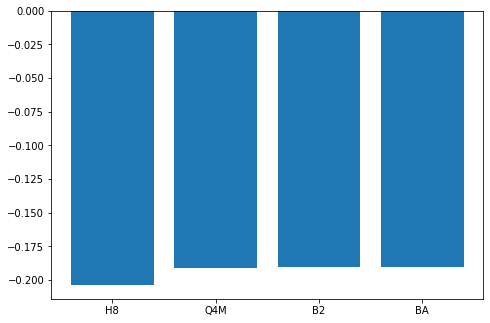

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
labels = ['H8', 'Q4M', 'B2', 'BA']
values = [sol_fem_3d, sol_fem_2d_M, sol_fem_1d_B2, sol_exact]
ax.bar(labels, values)
plt.show()
